In [29]:
import sys
sys.path.insert(0,"../")
import time

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from botorch import *
from botorch import fit_gpytorch_model
from botorch.models import HeteroskedasticSingleTaskGP, FixedNoiseGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch

In [30]:
# Util: Mute prints within
from contextlib import contextmanager
import sys, os

@contextmanager
def mute_print(mute=True):
    if mute == True:
        original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        yield
        sys.stdout = original_stdout

In [31]:
train_X = torch.rand(1, 1, 2, device="cuda:0", dtype=torch.double)
train_Y = torch.sin(train_X).sum(dim=-1, keepdim=True)
se = torch.norm(train_X, dim=-1, keepdim=True)
train_Yvar = 0.1 + se * torch.rand_like(train_Y, device="cuda:0", dtype=torch.double)

model_obj = HeteroskedasticSingleTaskGP(train_X, train_Y, train_Yvar).to(train_X)
model_con = FixedNoiseGP(train_X, torch.tensor(0.0, device="cuda:0").expand_as(train_Y), 
                         torch.tensor(0.0, device="cuda:0").expand_as(train_Yvar))\
                .to(train_X)
# combine into a multi-output GP model
model = ModelListGP(model_obj, model_con) 
mll = SumMarginalLogLikelihood(model.likelihood, model)
# mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

print(f"Train X: {train_X.shape} -> Train Y: {train_Y.shape} with variance: {train_Yvar.shape}")
p = model.posterior(torch.cat([train_X, torch.tensor([0.1, 0.2]).view(1,1,2).to(train_X)]))


tensor([[3.4751],
        [3.3995],
        [3.3524],
        ...,
        [3.6853],
        [3.6853],
        [3.6853]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward>)

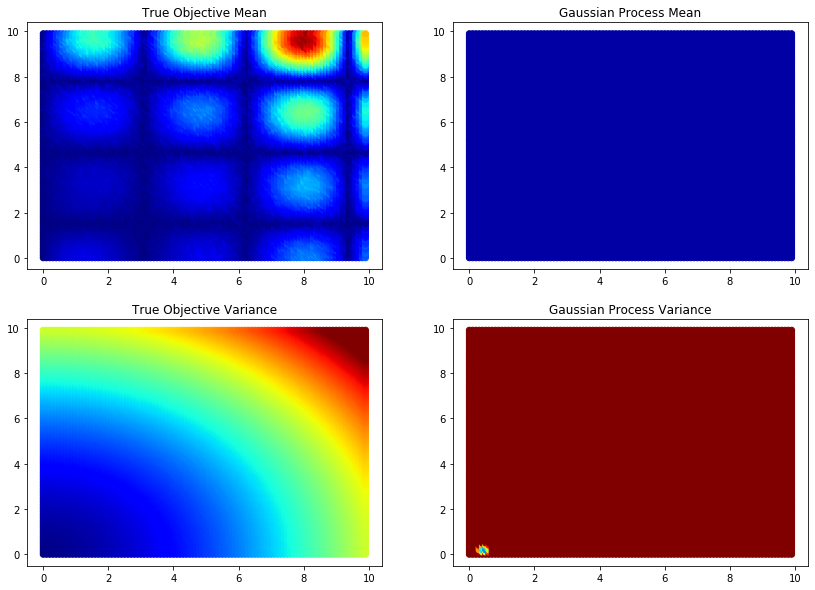

In [32]:
Y_sample, Yvar_sample = sample_model_posterior(model, X)
y_sample_cmap = [cmap((k.item()-mean_min_height)/mean_max_height) for k in Y_sample] 
yvar_sample_cmap = [cmap((k.item()-var_min_height)/var_max_height) for k in Yvar_sample] 

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(221)
ax1.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=y_obj_cmap)
ax1.set_title("True Objective Mean")

ax2 = fig.add_subplot(223)
ax2.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=yvar_obj_cmap)
ax2.set_title("True Objective Variance")

ax3 = fig.add_subplot(222)
ax3.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=y_sample_cmap)
ax3.set_title("Gaussian Process Mean")

ax4 = fig.add_subplot(224)
ax4.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=yvar_sample_cmap)
ax4.set_title("Gaussian Process Variance")
plt.show()

In [5]:
from botorch.test_functions import HolderTable

BASE_VAR = 0.1

def objective(X):
    neg_holdertable = HolderTable(noise_std=0.0, negate=True)
    Y = neg_holdertable(X.view(-1, 2))
    
    se = torch.norm(X, dim=-1, keepdim=True) * 0.1
    Yvar = BASE_VAR + se * torch.rand_like(se)
    true_var = BASE_VAR + se
    Y = Y.view(-1, 1, 1) + torch.rand_like(se) * Yvar
    return Y, Yvar.view_as(Y)**2, true_var.view_as(Y)**2

def sample_model_posterior(model, X):
    p = model.posterior(X.view(-1,1,2))
    return p.mean[:,:,0], p.variance[:,:,0]

In [39]:
Yvar_sample.max()

tensor(0.6906, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)

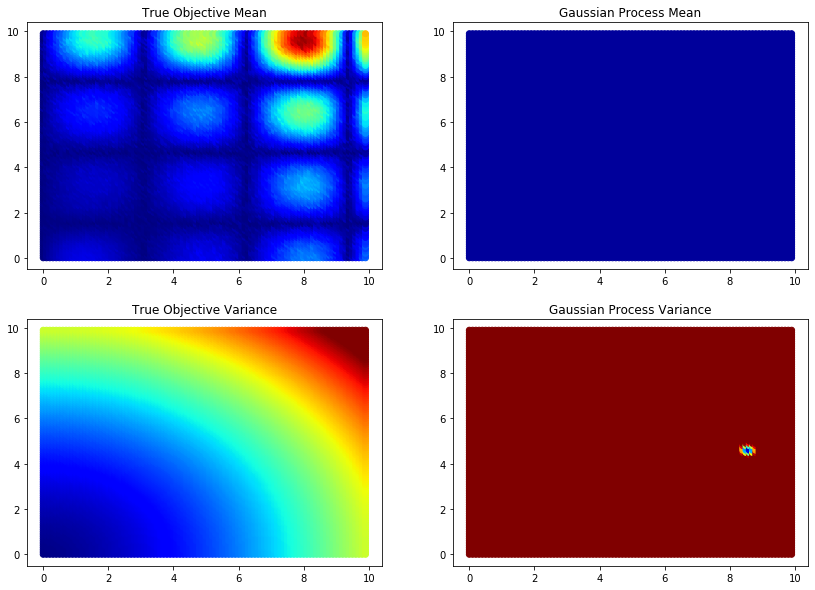

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


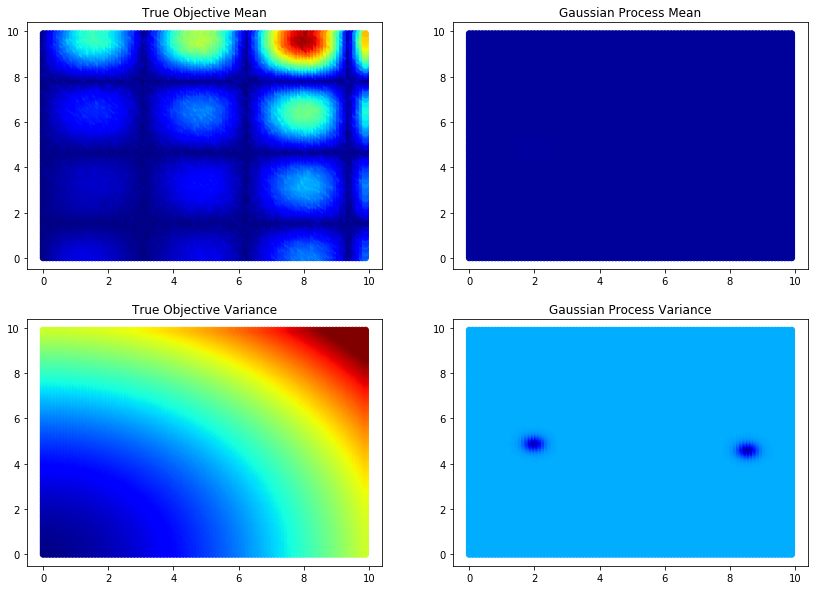

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


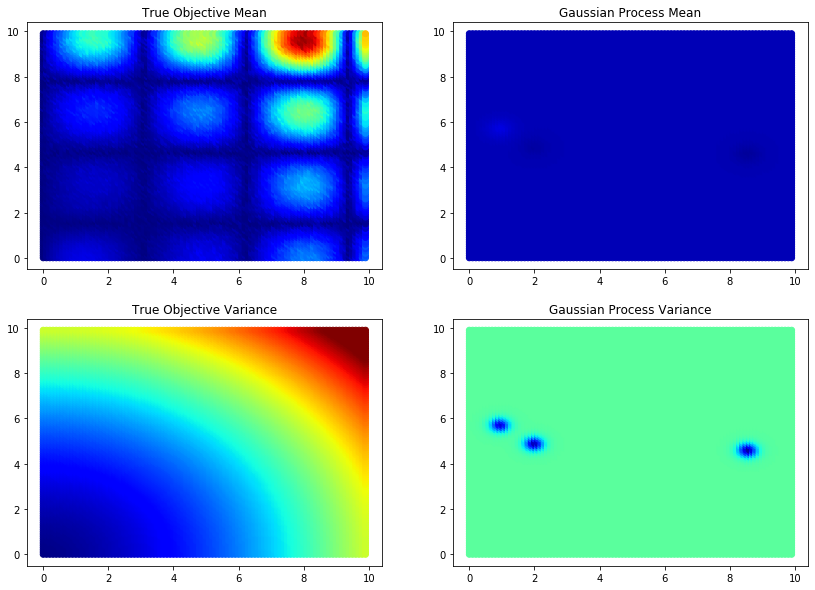

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


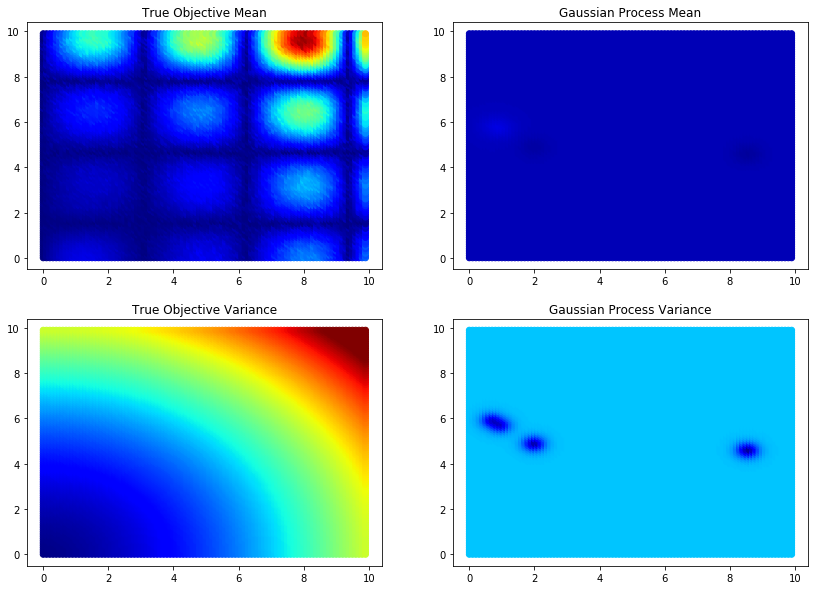

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


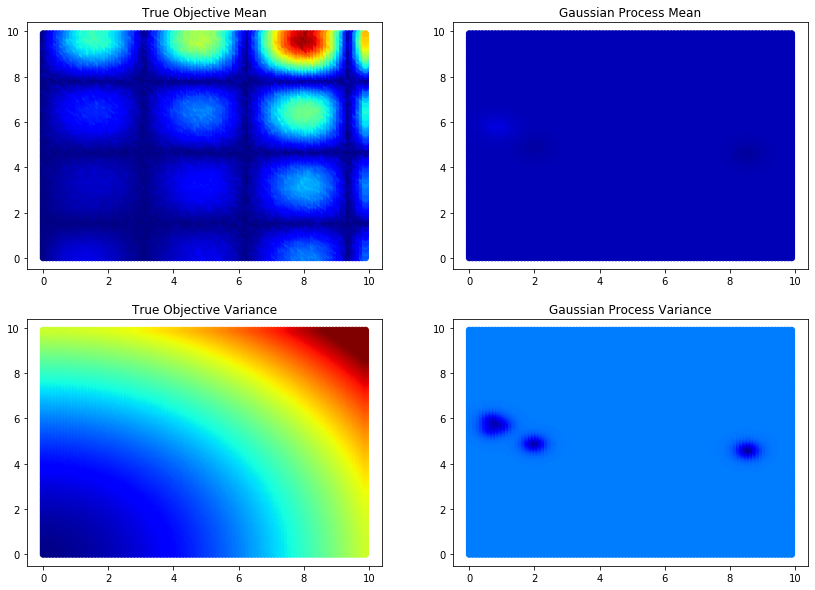

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


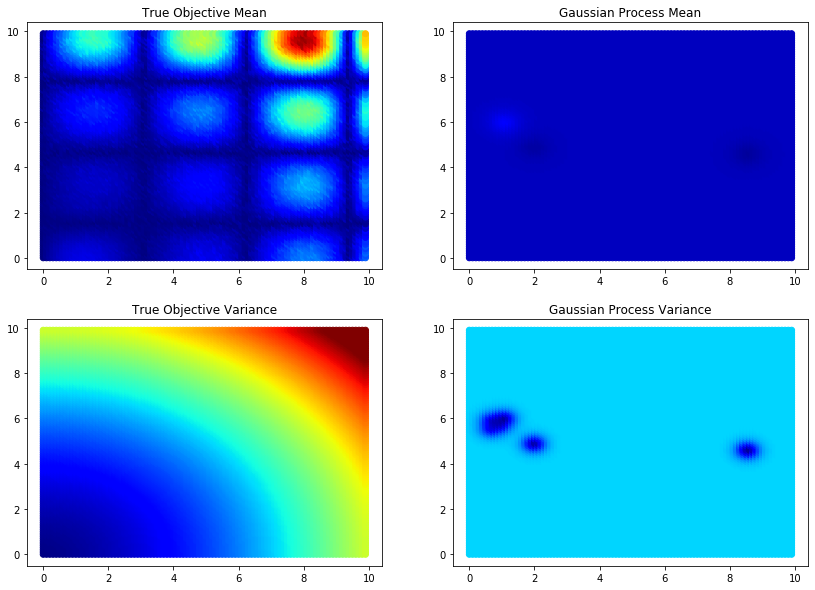

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


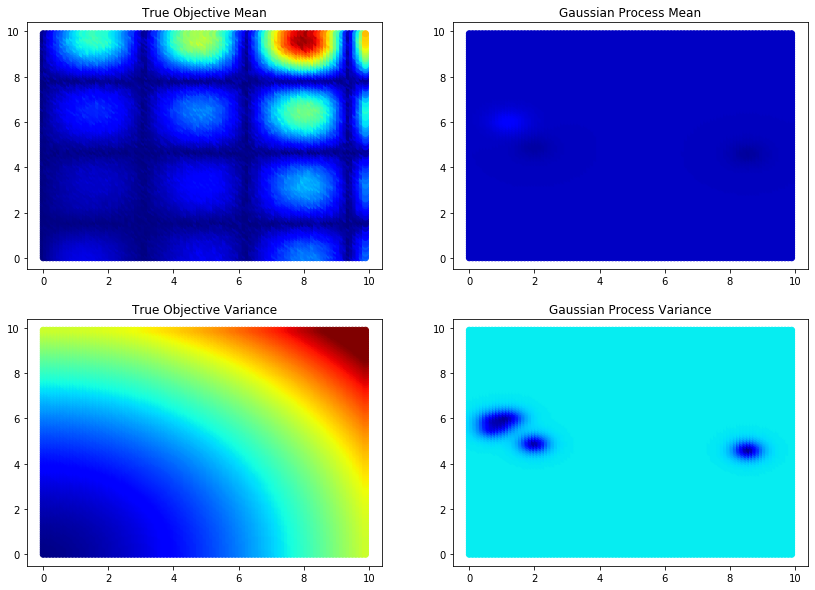

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


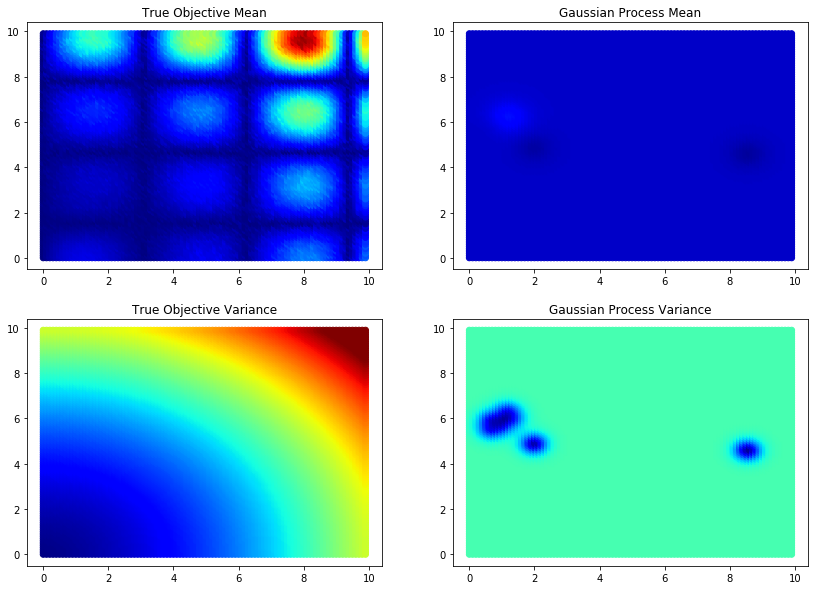

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


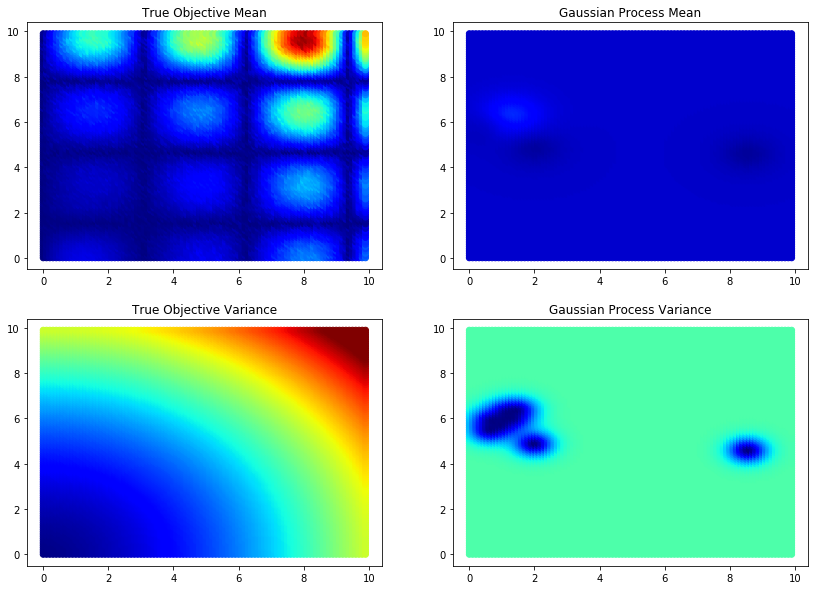

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


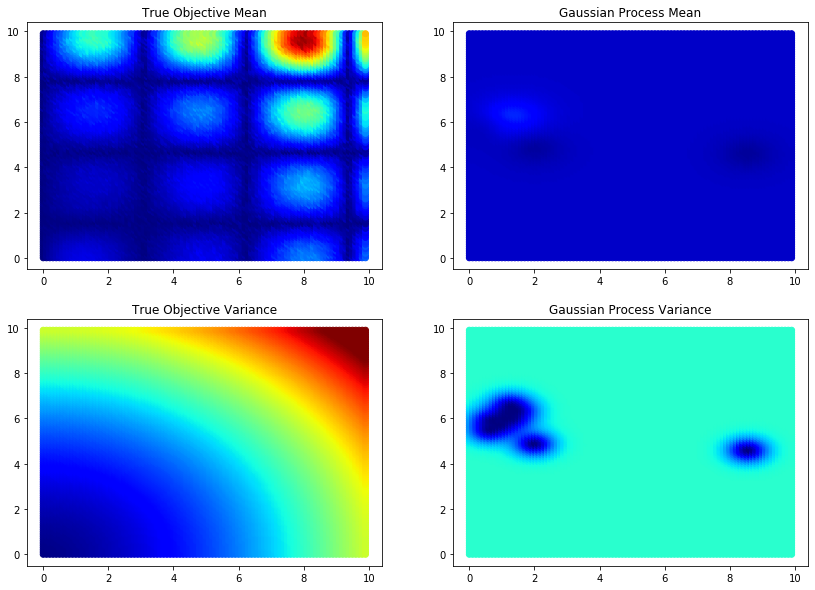

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


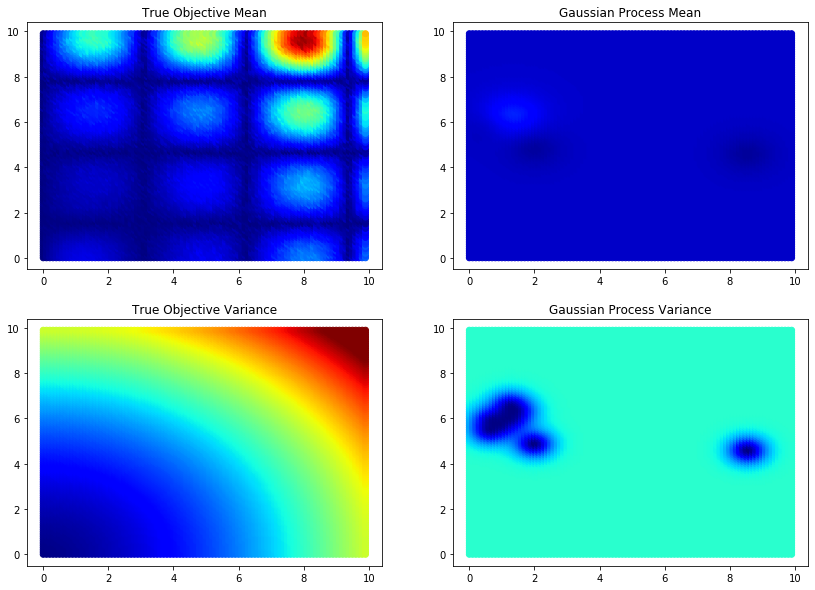

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


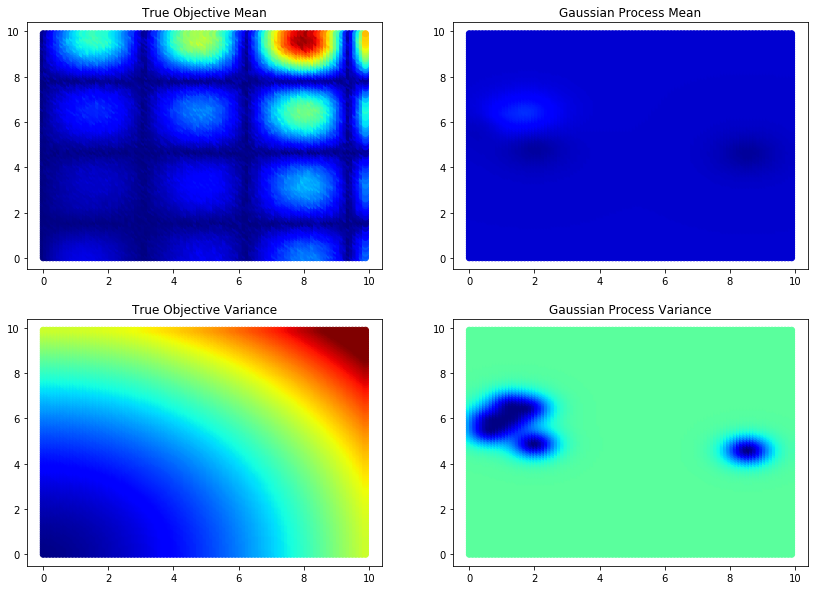

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


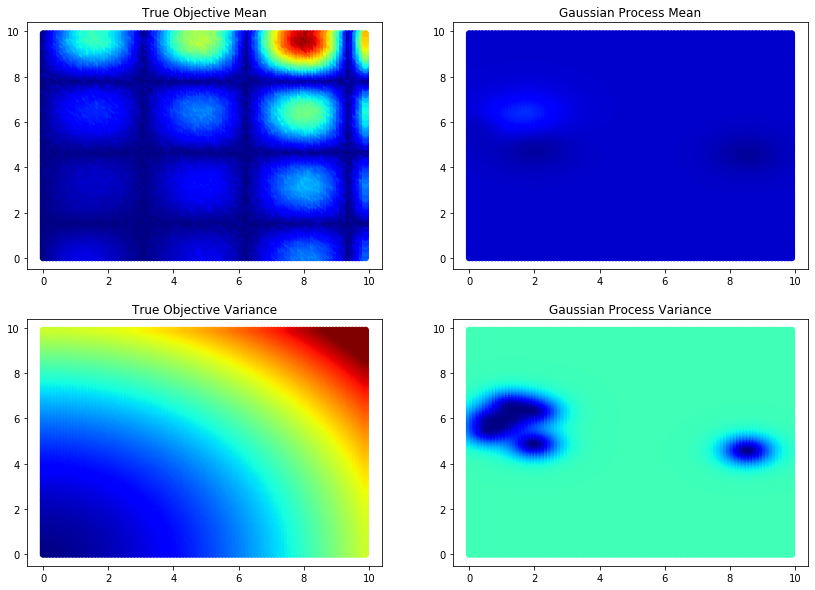

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


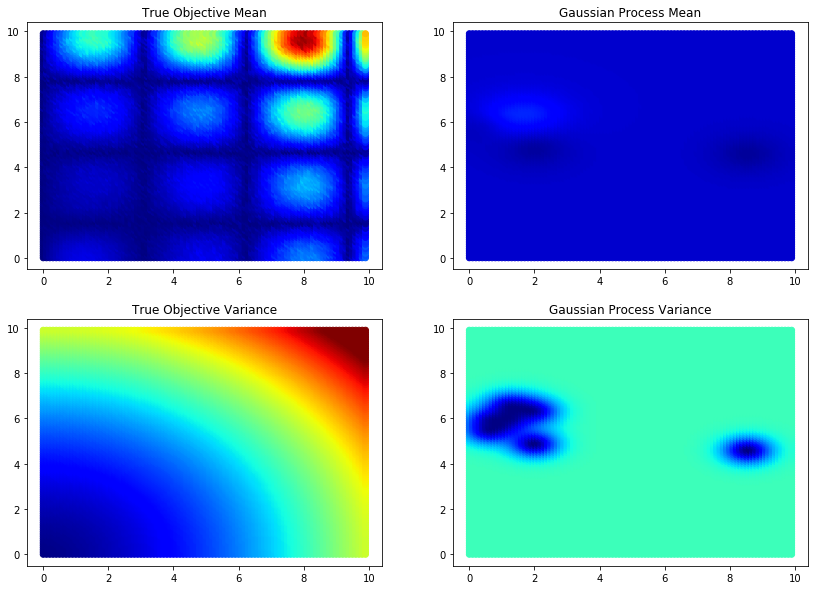

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


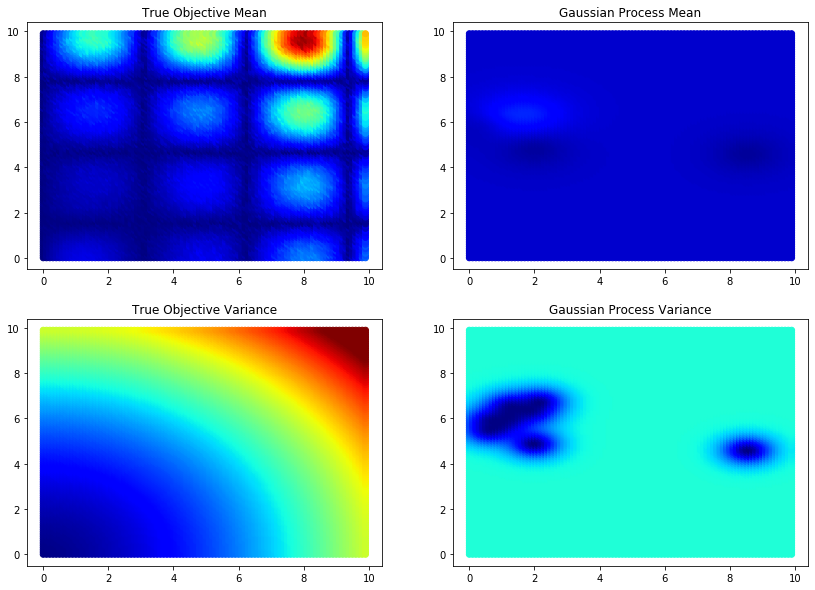

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


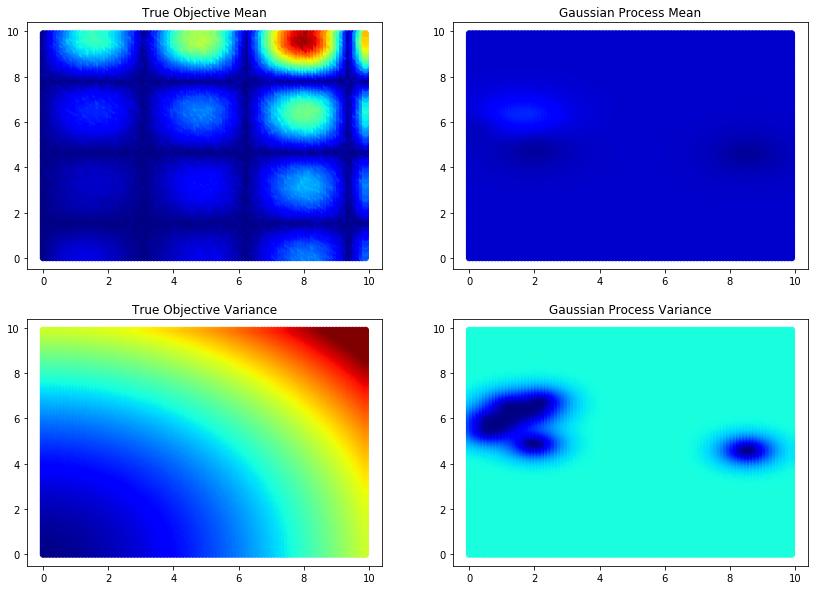

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


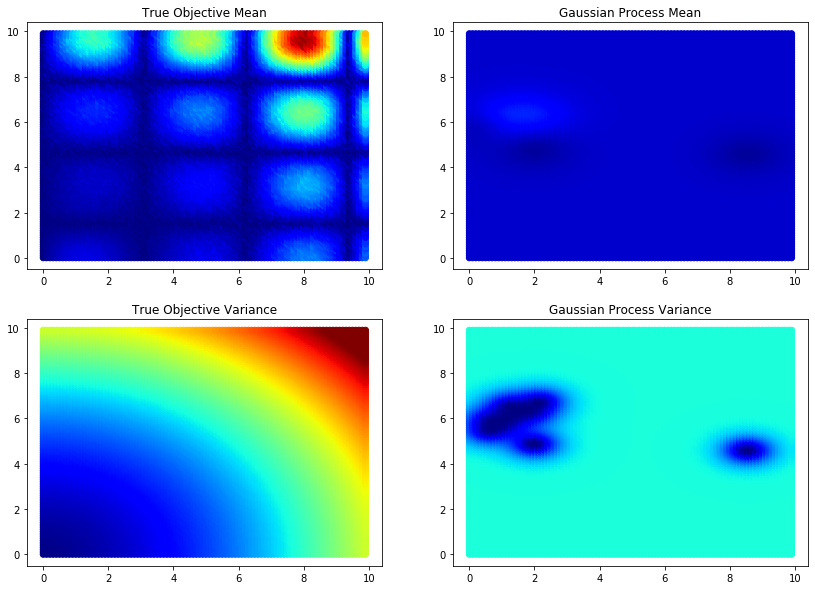

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


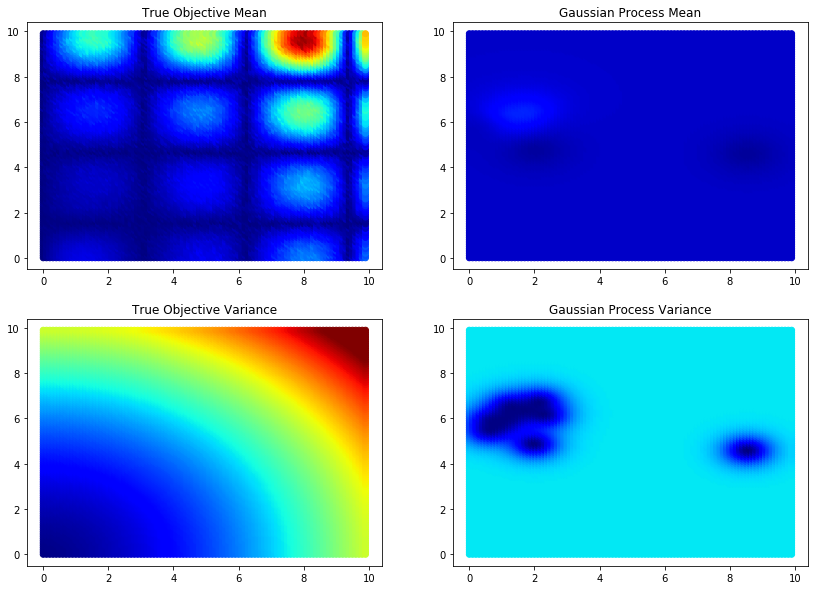

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


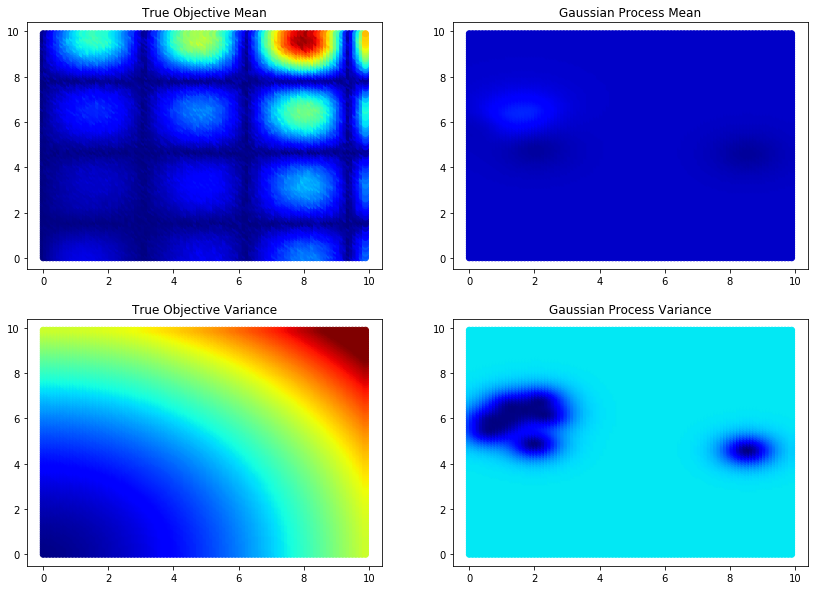

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


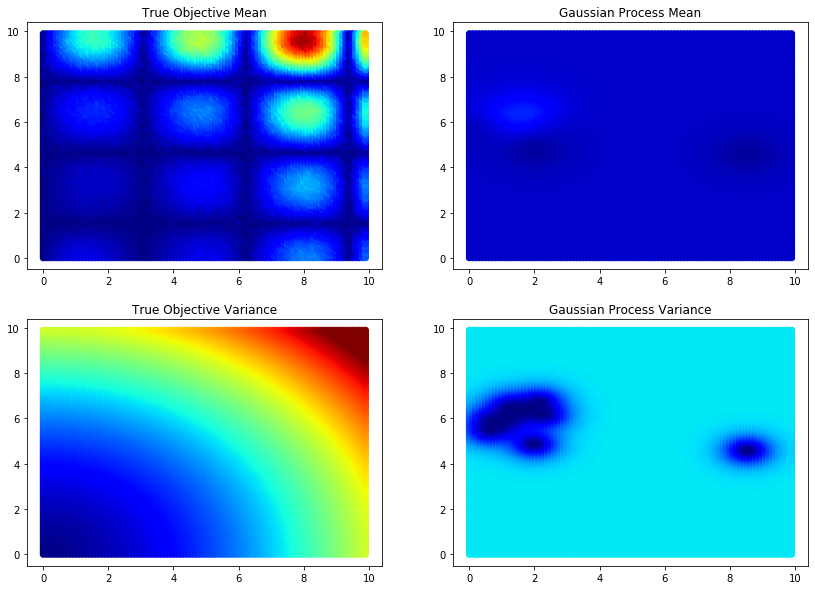

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


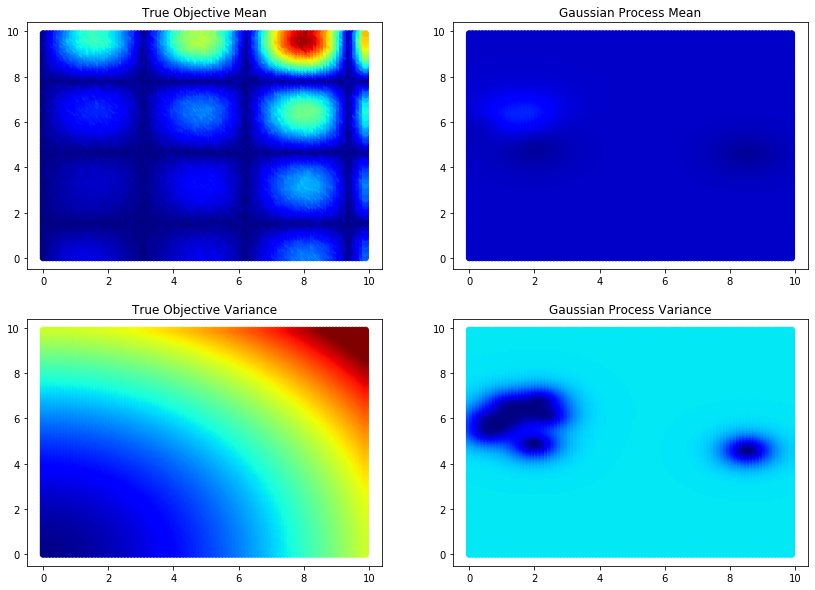

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


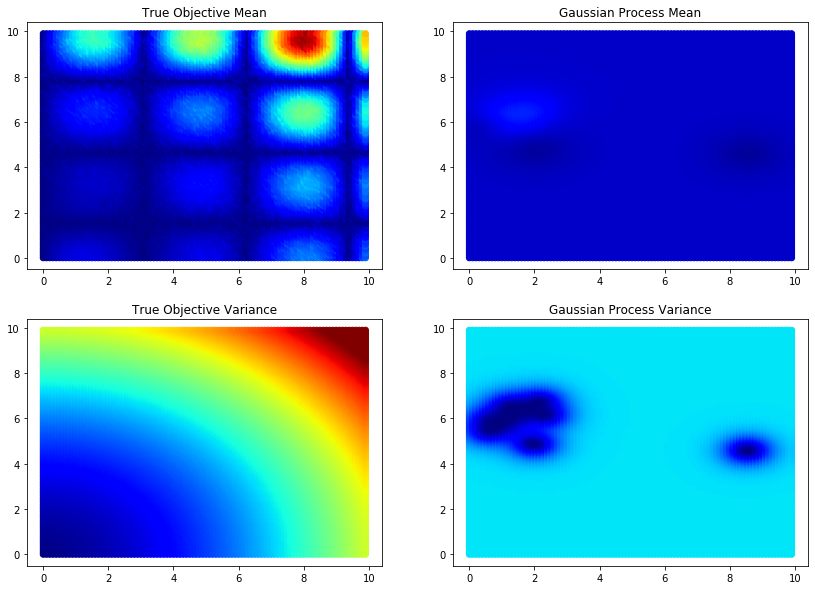

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


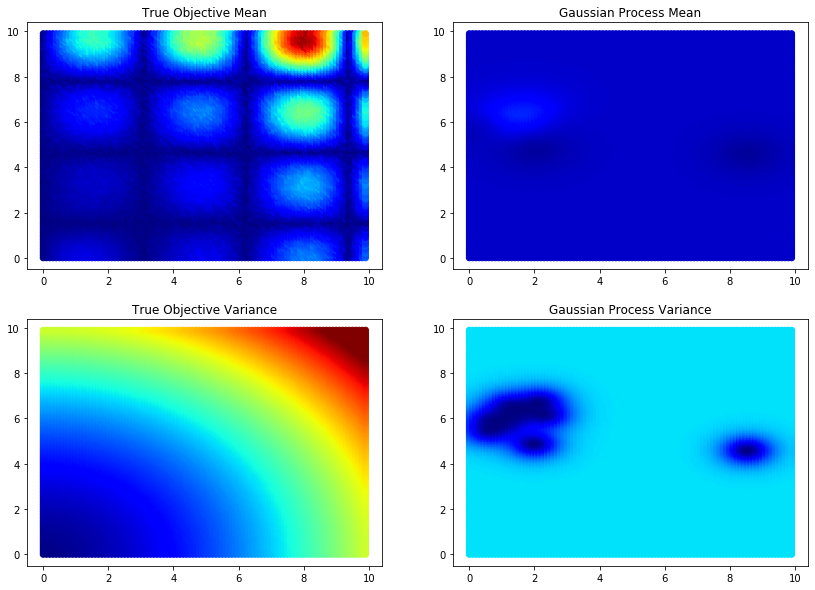

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


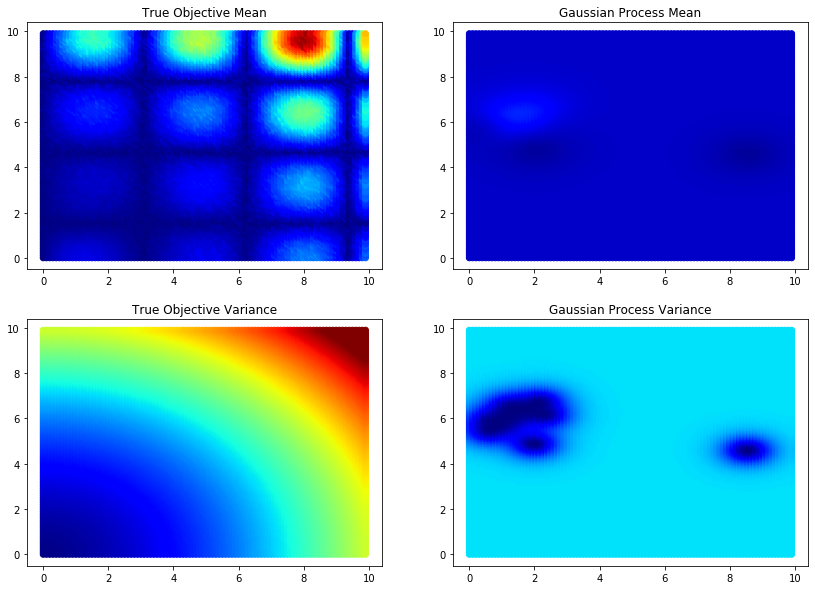

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


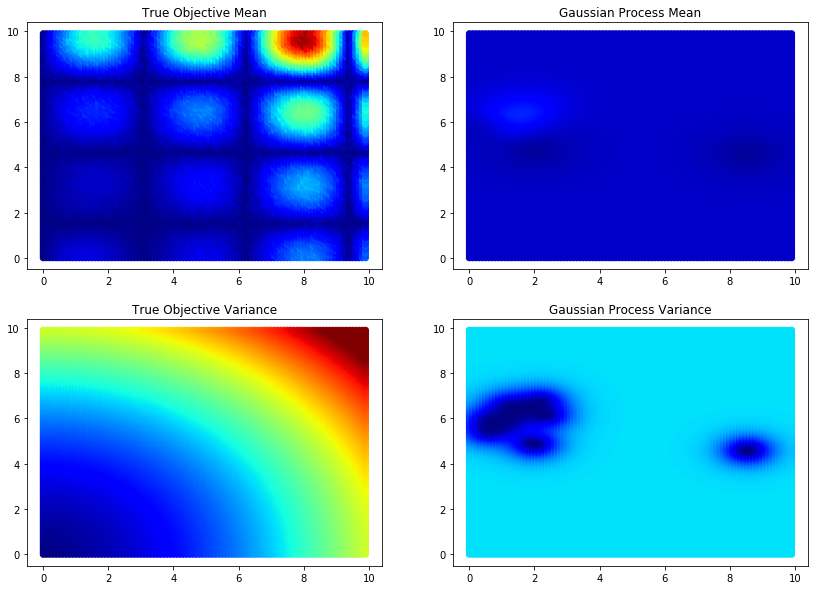

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


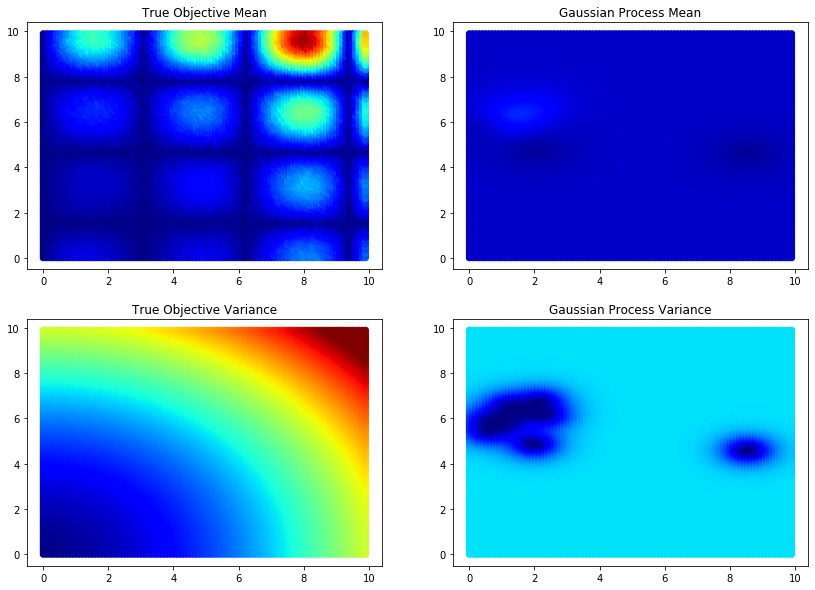

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


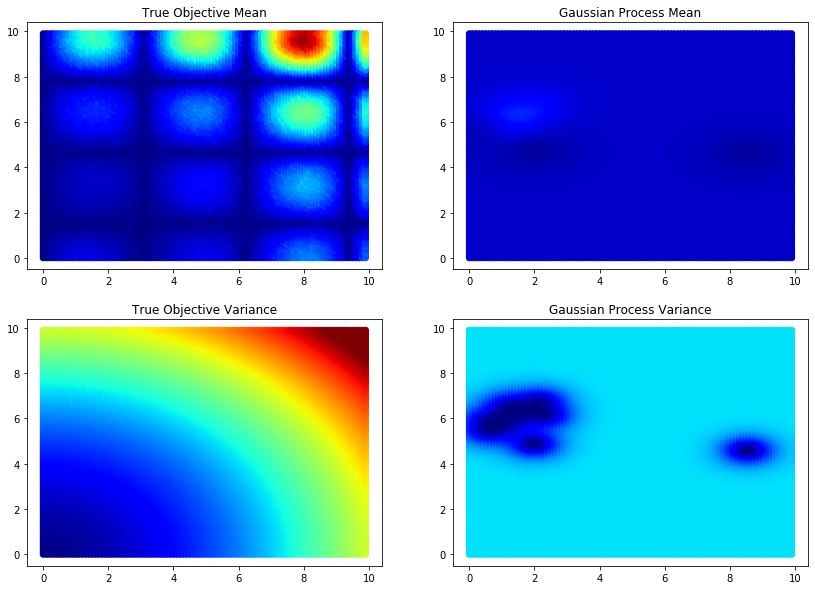

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


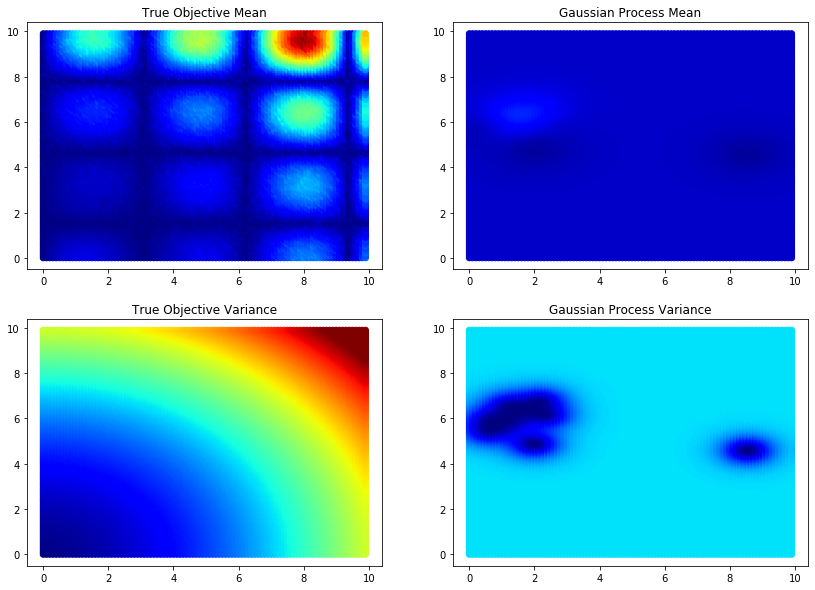

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


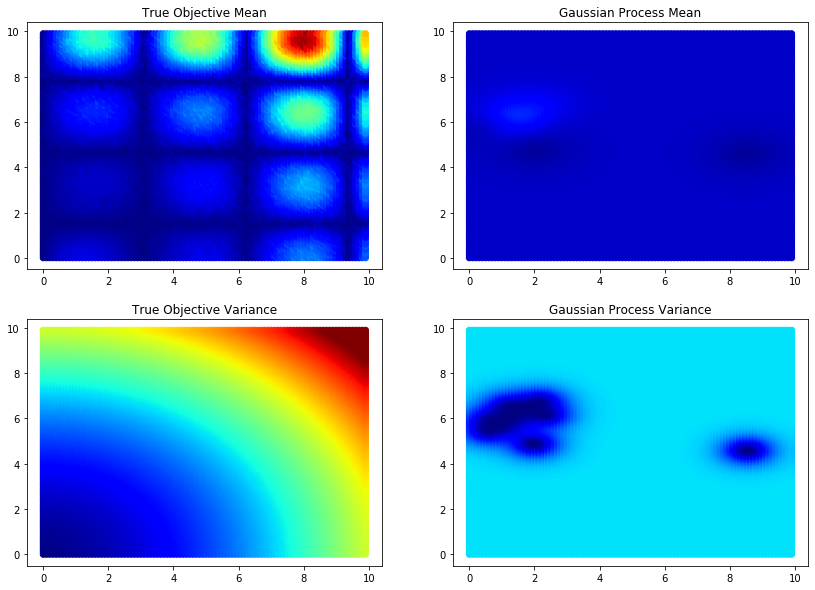

/home/tung/.local/lib/python3.7/site-packages/botorch/gen.py:125: OptimizeWarning: Unknown solver options: max_iter, seed
  options={k: v for k, v in options.items() if k != "method"},
/home/tung/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


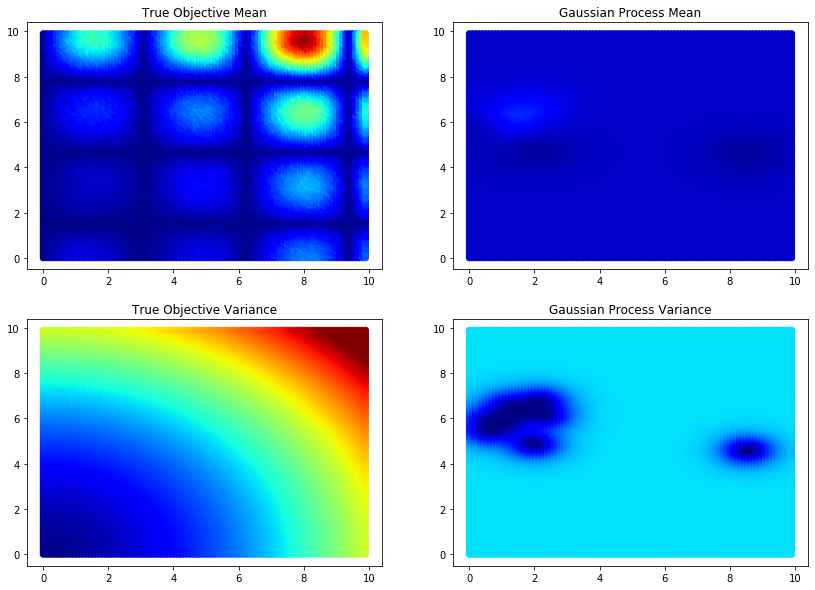

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from time import sleep
from IPython.display import clear_output

from dopt import NEIOptimizer

bounds = {
    "x1": [0, 10],
    "x2": [0, 10]
}
optimizer = NEIOptimizer("test.dopt", bounds, device="cuda:0")

X = torch.cartesian_prod(torch.arange(0,1,0.01, dtype=torch.double), torch.arange(0,1,0.01, dtype=torch.double))\
                            .view(-1,1,2) * 10
X = X.to("cuda:0")
Y, Yvar, true_var = objective(X)

cmap = cm.get_cmap('jet') 
# Displaying colors for mean
mean_max_height = 20
mean_min_height = 0
y_obj_cmap = [cmap((k.item()-mean_min_height)/mean_max_height) for k in Y] 
# Displaying colors for variance
var_max_height = 2
var_min_height = 0
yvar_obj_cmap = [cmap((k.item()-var_min_height)/var_max_height) for k in true_var] 

num_iter = 30
while num_iter > 0:
    
    with mute_print():
        new_candidate = optimizer.generate_candidate()
    
    print(X.device)
    mean, var, _ = objective(
        torch.tensor(list(new_candidate.values()),
                     device=optimizer.device, dtype=NEIOptimizer.DTYPE))
    optimizer.observations.append({
        "candidate": new_candidate,
        "result": [mean.item(), var.item()],
        "feasibility": 0,
    })
    mll, model = optimizer._initialize_model()
    fit_gpytorch_model(mll)
    print(f"Obtained var: {var}, Model var: {sample_model_posterior(model, torch.tensor(list(new_candidate.values()), device=optimizer.device, dtype=NEIOptimizer.DTYPE))}")
    Y_sample, Yvar_sample = sample_model_posterior(model, X)
    y_sample_cmap = [cmap((k.item()-mean_min_height)/mean_max_height) for k in Y_sample] 
    yvar_sample_cmap = [cmap((k.item()-var_min_height)/var_max_height) for k in Yvar_sample] 
    
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(221)
    ax1.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=y_obj_cmap)
    ax1.set_title("True Objective Mean")

    ax2 = fig.add_subplot(223)
    ax2.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=yvar_obj_cmap)
    ax2.set_title("True Objective Variance")

    ax3 = fig.add_subplot(222)
    ax3.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=y_sample_cmap)
    ax3.set_title("Gaussian Process Mean")

    ax4 = fig.add_subplot(224)
    ax4.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=yvar_sample_cmap)
    ax4.set_title("Gaussian Process Variance")
    plt.show()
#     clear_output(wait=True)
    sleep(3)
    
    num_iter -= 1

In [54]:
s = {'acet': {'tst008@acet116-lnx-10.bucknell.edu': [], 'tst008@acet116-lnx-11.bucknell.edu': [], 'tst008@acet116-lnx-12.bucknell.edu': [], 'tst008@acet116-lnx-13.bucknell.edu': [], 'tst008@acet116-lnx-14.bucknell.edu': [], 'tst008@acet116-lnx-15.bucknell.edu': [], 'tst008@acet116-lnx-16.bucknell.edu': [], 'tst008@acet116-lnx-17.bucknell.edu': [], 'tst008@acet116-lnx-18.bucknell.edu': [], 'tst008@acet116-lnx-20.bucknell.edu': [], 'tst008@acet116-lnx-21.bucknell.edu': []}, 'localhost': {'localhost': []}}
sum([sum([1 for g in i.values()]) for i in s.values()])

12

In [ ]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(221)
ax1.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=y_obj_cmap)
ax1.set_title("True Objective Mean")

ax2 = fig.add_subplot(223)
ax2.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=yvar_obj_cmap)
ax2.set_title("True Objective Variance")

ax3 = fig.add_subplot(222)
ax3.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=y_sample_cmap)
ax3.set_title("Gaussian Process Mean")

ax4 = fig.add_subplot(224)
ax4.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=yvar_sample_cmap)
ax4.set_title("Gaussian Process Variance")
plt.show()

In [ ]:
import numpy as np
np.mean([1,2,3])